In [11]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.utils import resample
from sklearn.metrics import r2_score, ndcg_score
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr


In [12]:
ALL_AAS = ("A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y")
def diff_letters(a, b = 'VDGV'):
    return sum ( a[i] != b[i] for i in range(len(a)) )


In [44]:
class GB1XDataset(Dataset):
    
    def __init__(self, file_path):
        full_sequence = True
        
        self.data = pd.read_csv(file_path)
        self.data['num_muts'] = self.data['Combo'].apply(diff_letters)

        #only select variants with 2 or less mutations
        #self.data = self.data[self.data['num_muts'] <= 2]
        
        self.all_combos = self.data["Combo"]
        if full_sequence:
            self.all_combos = self.all_combos.apply(generate_full)
        self.n_positions_combined = len(self.all_combos[0])

        self.X = torch.tensor(self._generate_onehot()).float()
        self.attributes = self.data[["Triad-FixedBb-dG"]].values # "Triad-FixedBb-dG", "esm_msa1_t12_100M_UR50S-Naive-ColumnUnmasked" ,	"esm_msa1_t12_100M_UR50S-Conditional-ColumnUnmasked", "esm_msa1_t12_100M_UR50S-Naive-ColumnMasked", "esm_msa1_t12_100M_UR50S-Conditional-ColumnMasked"]].values
        #"Triad-FlexibleBb-dG", "Triad-FlexibleBb-RMSD"
        self.y = self.data["Fitness"].values

    #function that generates onehot encodings
    def _generate_onehot(self):
        """
        Builds a onehot encoding for a given combinatorial space.
        """
        # Make a dictionary that links amino acid to index
        one_hot_dict = {aa: i for i, aa in enumerate(ALL_AAS)}
    
        # Build an array of zeros
        onehot_array = np.zeros([len(self.all_combos), self.n_positions_combined, 20])
        
        # Loop over all combos. This should all be vectorized at some point.
        for i, combo in enumerate(self.all_combos):
            
            # Loop over the combo and add ones as appropriate
            for j, character in enumerate(combo):
                
                # Add a 1 to the appropriate position
                onehot_ind = one_hot_dict[character]
                onehot_array[i, j, onehot_ind] = 1
                
        # Return the flattened array
        return onehot_array.reshape(onehot_array.shape[0],-1)
    
    def generate_full(combo):
        seq = "MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE"
        seq = seq[:38] + combo[0] + combo[1] + combo[2] + seq[41:53] + combo[3] + seq[54:]
        return seq
          
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):            
        return self.X[index]

In [45]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#torch.cuda.device_count()
cuda0 = torch.cuda.set_device(0)

# Hyper-parameters
#input_dim = 80 #initial dimension
#h_dim1 = 64 #hidden layer dimension 1
#h_dim2 = 32 #hidden layer dimension 2
#z_dim = 16 #embedding dimension

h_dim1 = 512 #hidden layer dimension 1
h_dim2 = 256 #hidden layer dimension 2
z_dim = 128 #embedding dimension
num_epochs = 20

batch_size = 128
learning_rate = 1e-3
variational = False #if True, trains a variational autoencoder instead of an autoencoder

# GB1 dataset
dataset = GB1XDataset('./data/AllPredictions.csv')
input_dim = dataset.n_positions_combined*20 #initial dimension

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

# VAE/AE model
class ProtTP(nn.Module):
    def __init__(self, input_dim=80, h_dim1=64, h_dim2=32, z_dim=16, variational=False):
        super(ProtTP, self).__init__()

        #define them here or in sequential?
        self.fce1 = nn.Linear(input_dim, h_dim1)
        self.fce2 = nn.Linear(h_dim1, h_dim2)
        self.fce3 = nn.Linear(h_dim2, z_dim)
        self.fcvar = nn.Linear(h_dim2, z_dim)

        self.fcd1 = nn.Linear(z_dim, h_dim2)
        self.fcd2 = nn.Linear(h_dim2, h_dim1)
        self.fcd3 = nn.Linear(h_dim1, input_dim)
        
    def encode(self, x):
        h1 = F.relu(self.fce1(x))
        h2 = F.relu(self.fce2(h1))
        if variational:
            return self.fce3(h2), self.fcvar(h2)
        else:
            return self.fce3(h2)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h1 = F.relu(self.fcd1(z))
        h2 = F.relu(self.fcd2(h1))
        return torch.sigmoid(self.fcd3(h2))
    
    def forward(self, x):
        if variational:
            mu, log_var = self.encode(x)
            z = self.reparameterize(mu, log_var)
            x_reconst = self.decode(z)
            return x_reconst, mu, log_var
        else:
            z = self.encode(x)
            x_reconst = self.decode(z)
            return x_reconst, z
        
model = ProtTP(input_dim=input_dim, h_dim1=h_dim1, h_dim2=h_dim2, z_dim=z_dim, variational=variational).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda


In [46]:
# Start training
best_loss = 0
for epoch in range(num_epochs):
    for i, x in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, input_dim)

        if variational:
            x_reconst, mu, log_var = model(x)
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) 
        else:
            x_reconst, z = model(x)
            kl_div = 0
        
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        loss = reconst_loss + kl_div
        
        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 1167 == 0:
            if variational:
                print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                    .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
            else:
                print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}"
                    .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()))
    
    #update the best model after each epoch
    if epoch == 0 or loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), 'best_AE.pth')
        print('Best model saved')

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/20], Step [1167/1167], Reconst Loss: 1415.5044
Best model saved
Epoch[2/20], Step [1167/1167], Reconst Loss: 672.2246
Best model saved
Epoch[3/20], Step [1167/1167], Reconst Loss: 19.6294
Best model saved
Epoch[4/20], Step [1167/1167], Reconst Loss: 1.5969
Best model saved
Epoch[5/20], Step [1167/1167], Reconst Loss: 904.8995
Epoch[6/20], Step [1167/1167], Reconst Loss: 800.7776
Epoch[7/20], Step [1167/1167], Reconst Loss: 1.2516
Best model saved
Epoch[8/20], Step [1167/1167], Reconst Loss: 0.2435
Best model saved
Epoch[9/20], Step [1167/1167], Reconst Loss: 0.0951
Best model saved
Epoch[10/20], Step [1167/1167], Reconst Loss: 0.0491
Best model saved
Epoch[11/20], Step [1167/1167], Reconst Loss: 0.0219
Best model saved
Epoch[12/20], Step [1167/1167], Reconst Loss: 45200.0000
Epoch[13/20], Step [1167/1167], Reconst Loss: 45200.0000
Epoch[14/20], Step [1167/1167], Reconst Loss: 45200.0000
Epoch[15/20], Step [1167/1167], Reconst Loss: 45200.0000
Epoch[16/20], Step [1167/1167], Rec

In [48]:
#Get embeddings
model.load_state_dict(torch.load('best_AE.pth'))

with torch.no_grad():
    X = dataset.X.to(device)
    if variational:
        mu, log_var = model.encode(X)
        embeddings = model.reparameterize(mu, log_var)
    else:
        embeddings = model.encode(X)
    reconstructions = model.decode(embeddings)

In [49]:
#downstream supervised regression
N_models = 1000
N_train_samples = 384
N_test_samples = 32
alpha = 0.01

X_baseline = np.array(dataset.X)
X_OHembed = np.concatenate((np.array(dataset.X), np.array(embeddings.cpu())), axis=1)
#X_OHembed = np.array(embeddings.cpu())
X_zs = np.concatenate((np.array(dataset.X), np.array(dataset.attributes)), axis=1)
#X_zs = np.array(dataset.attributes)

inputs = [X_baseline, X_OHembed, X_zs]
#inputs = [X_baseline, X_zs]

results = np.zeros((N_models, len(inputs)*2))
for j, X in enumerate(inputs):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = dataset.y

    X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    for i in range(N_models):
        X_train, y_train = resample(X_train_all, y_train_all, n_samples=N_train_samples)
        #only run this line if you wish to use a different test size
        #X_test, y_test = resample(X, y, n_samples=N_test_samples)
        
        clf = Ridge(alpha=alpha)
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        results[i, j] = ndcg_score([y_test], [y_pred_test])
        results[i, 3+j] = spearmanr(y_test, y_pred_test)[0]

In [50]:
data = dataset.data
#scores = data["EvMutation"]#[:100]
scores = data["Triad-FixedBb-dG"]#[:32000]
#scores = data["esm_msa1_t12_100M_UR50S-Naive-ColumnUnmasked"][:100]
fitness = data['Fitness']#[:100]
print(ndcg_score([fitness], [scores]))
spearmanr(fitness, scores)

0.7795078103627929


SpearmanrResult(correlation=0.26618221245239015, pvalue=0.0)

OH NDCG       0.627293
OH+AE NDCG    0.629832
OH+ZS NDCG    0.628010
OH rho        0.142926
OH+AE rho     0.148957
OH+ZS rho     0.146466
dtype: float64


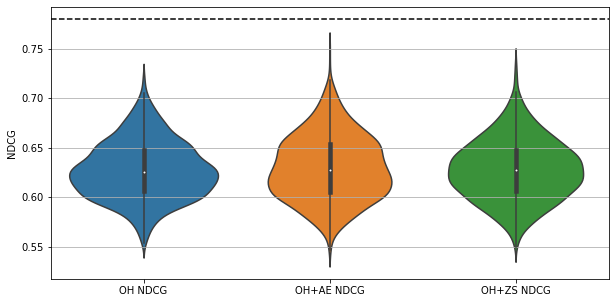

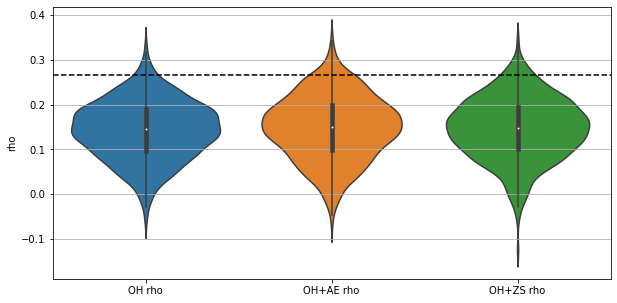

In [51]:
#increasing the NDCG increase ridge model performance
results = pd.DataFrame(data=results, columns= ['OH NDCG', 'OH+AE NDCG', 'OH+ZS NDCG', 'OH rho', 'OH+AE rho','OH+ZS rho'])

plt.figure(figsize=(10,5))
plt.grid()
ax = sns.violinplot(data = results.iloc[:,:3])
plt.axhline(y = ndcg_score([fitness], [scores]), color = 'k', linestyle = '--')
plt.ylabel('NDCG')

plt.figure(figsize=(10,5))
plt.grid()
ax = sns.violinplot(data = results.iloc[:,3:])
plt.axhline(y = spearmanr(fitness, scores)[0], color = 'k', linestyle = '--')
plt.ylabel('rho')

print(np.mean(results, axis =0))


Text(336.9714285714286, 0.5, 'Actual fitness')

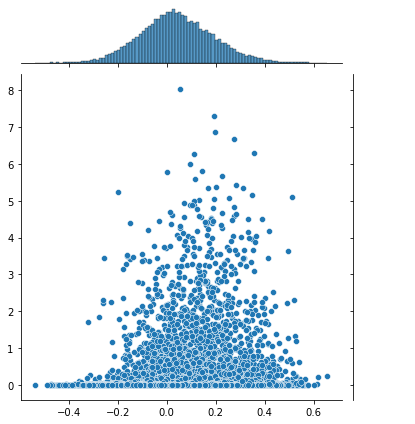

In [52]:
ax = sns.jointplot(x = y_pred_test,y = y_test)
plt.xlabel('Predicted fitness')
plt.ylabel('Actual fitness')

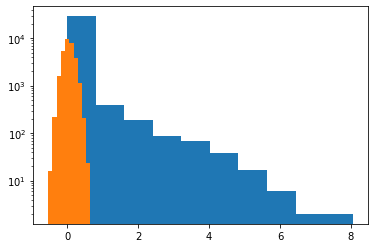

In [53]:
plt.hist(y_test)
plt.hist(y_pred_test)
plt.yscale('log')

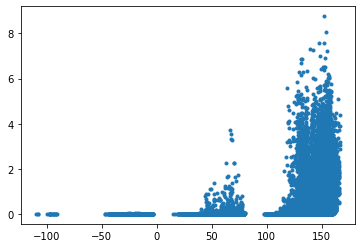

In [54]:
plt.plot(scores, fitness, '.')